In [1]:
import os
import sys
sys.path.append('../sdbm/code')
sys.path.append('../DeepView/deepview')
sys.path.append('../dbm_evaluation')
# import make blobs
from sklearn.datasets import make_blobs
# import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import torch as T
import torch.linalg as LA

from ssnp import SSNP
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

from map_evaluation import P_wrapper, MapBuilder

sys.path.append('../GAN_inverse_projection')
from utils import GANinv, CGANinv
from umap import UMAP

In [2]:
import tensorflow as tf
# check GPU
print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices('GPU'))


/device:GPU:0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# %matplotlib widget

In [4]:
class My_wrapper:
    def __init__(self, P, Pinv):
        self.P = P
        self.Pinv = Pinv

    def transform(self, X):
        return self.P.transform(X)
    
    def inverse_transform(self, x_2d):
        return self.Pinv.transform(x_2d)
    
    def fit(self, X, y=None, clf=None):
        x_2d = self.P.fit_transform(X,)
        self.Pinv.fit(X_2d=x_2d, X=X)


projecter = My_wrapper(UMAP(), CGANinv())

In [5]:
X, y = make_blobs(n_samples=1000, centers=5, n_features=50, random_state=0)
X = MinMaxScaler().fit_transform(X)
clf = LogisticRegression(random_state=0).fit(X, y)

# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# ssnp = SSNP(bottleneck_activation='linear', verbose=0)
# ssnp.fit(X, y, )

projecter = P_wrapper(deepview=0, ssnp=1, NNinv_Torch=0)
projecter.fit(X, y, clf)

device:  /device:GPU:0
fitting time:  3.0082321166992188


3.0082321166992188

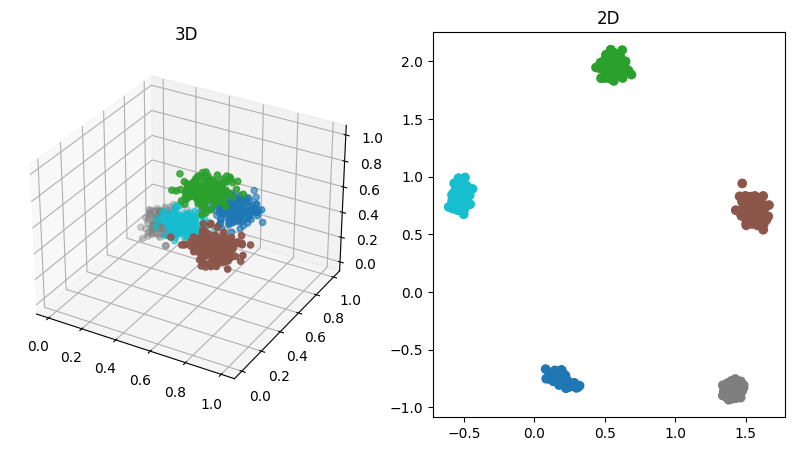

In [6]:
X_2d = projecter.transform(X)
# plot 3d, and 2d
fig0 = plt.figure(figsize=(10, 5))
ax0 = fig0.add_subplot(121, projection='3d')
ax0.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='tab10')
ax0.set_title('3D')
ax = fig0.add_subplot(122)
ax.scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap='tab10')
ax.set_title('2D')
plt.show()

In [7]:
# class ID_finder:
#     def __init__(self):
#         self.LID_map = None
#         self.DM = None
#         self.device = T.device('cuda' if T.cuda.is_available() else 'cpu')

#     def get_LID(self, X_2d, DM, grid=100, sample_size=5, mode='dim', cmap='jet'):
#         self.DM = DM

#         pixel_w = (X_2d[:, 0].max() - X_2d[:, 0].min()) / (grid-1)
#         pixel_h = (X_2d[:, 1].max() - X_2d[:, 1].min()) / (grid-1)

#         xx, yy = np.meshgrid(np.linspace(X_2d[:, 0].min(), X_2d[:, 0].max(), grid),
#                             np.linspace(X_2d[:, 1].min(), X_2d[:, 1].max(), grid))
#         XY = np.c_[xx.ravel(), yy.ravel()]

#         LID_map = np.zeros(XY.shape[0])
#         data_shape = DM.inverse_transform(np.zeros((5 ,2)))
#         # print(data_shape)
#         LID_eval = np.zeros((XY.shape[0], data_shape.shape[1]))

#         fig, ax = plt.subplots(figsize=(5, 5))
#         ax.scatter(X_2d[:, 0], X_2d[:, 1], c=y , cmap='tab10')
#         ax.set_title('2D _debug')

#         for i, pix in tqdm(enumerate(XY)):
#             ax.scatter(pix[0], pix[1], c='r', marker='+')
#             subset = self.get_subset(pix, pixel_w, pixel_h, sample_size)
#             ax.scatter(subset[:, 0], subset[:, 1], c='g', marker='x')
#             local_cov = self.compute_cov(subset)
#             LID_eval[i] = local_cov
#             # value = self.process_results(local_cov, mode)
#             # LID_map[pix] = value
#         print(LID_eval.shape)
#         LID_map = self.process_results(LID_eval, mode)
#         print(LID_map.shape)
#         self.LID_map = LID_map.reshape(grid, grid)#.to('cpu').numpy()
#         self.LID_eval = LID_eval#.to('cpu').numpy()

#     def get_subset(self, center, w, h, n_samples):
#         # def sample_uniform_2d(center, size, n_samples):
#         """
#         Generate `n_samples` uniformly distributed within a square of `size` around `center`.

#         Parameters:
#         center (tuple): The center of the square (x, y).
#         size (float): The size of the square. Points will be generated in the range [center - size/2, center + size/2].
#         n_samples (int): The number of samples to generate.

#         Returns:
#         numpy.ndarray: An array of shape (n_samples, 2) containing the generated points.
#         """
#         x, y = center
#         lower = [x - w/2, y - h/2]
#         upper = [x + w/2, y + h/2]

#         samples = np.random.uniform(lower, upper, (n_samples, 2))
#         return samples

#     def compute_cov(self, subset):
#         # to cuda, then compute cov
#         subset = self.DM.inverse_transform(subset)
#         ax0.scatter(subset[:, 0], subset[:, 1], subset[:, 2], c='g', marker='x', s=10)
#         # subset = T.tensor(subset, dtype=T.float32, device=self.device)
#         cov = np.cov(subset.T)
#         # comput eigenvalues
#         eigvals = np.linalg.eigvalsh(cov)
#         # order the eigenvalues
#         # eigvals = T.sort(eigvals, descending=True)

#         return eigvals

#     def process_results(self, LID_eval, mode='dim'):
#         ## sort the eigenvalues, 
#         # if mode == 'dim', return how many dimensions are needed to explain 95% of the variance; if mode == 'percent', return the percentage of variance explained by the first 2 dimensions
#         ### LID_eval: (n_samples, n_features)
#                     # sort the eigenvalues
#         LID_eval = np.sort(LID_eval, axis=1)
#         # reverse the order
#         LID_eval = LID_eval[:, ::-1]
#         # cumsum
#         # LID_eval = np.cumsum(LID_eval, axis=1)
#         eval_sum = np.sum(LID_eval, keepdims=True, axis=1)

#         # divide by the total sum
#         LID_eval = LID_eval / eval_sum

#         if mode == 'dim':
#             # find the first value that is greater than 0.95
#             acum = np.cumsum(LID_eval, axis=1)
#             LID_val = np.argmax(acum > 0.98, axis=1) + 1
            
#         elif mode == 'percent':
#             # find the first value that is greater than 0.95
#             LID_val = np.sum(LID_eval[:, 0:2], axis=1, keepdims=True)
#         else:
#             raise ValueError('mode must be either dim or percent')
#         return LID_val



#     def plot_LID(self, X_2d, DM=None, ax=None, grid=50, cmap='jet', mode='dim', sample_size=10):
#         if DM != self.DM or self.LID_map is None:
#             self.DM = DM
#             # set the others to None
#             self.get_LID(X_2d, grid=grid, DM=DM, mode=mode, sample_size=sample_size)

#         map = np.flip(self.LID_map, axis=0)
#         # map = self.LID_map
#         if ax is None:
#             plt.imshow(map, cmap=cmap)
#             # cbar of this plot
#             plt.colorbar()

#         else:
#             ax.imshow(map, cmap=cmap)
#             # ax.colorbar()
#             # cbar of this plot
#             fig = ax.get_figure()
#             cax = fig.add_axes([0.95, 0.1, 0.03, 0.8])
#             norm = mpl.colors.Normalize(vmin=map.min(), vmax=map.max())
#             mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm)

In [8]:
# class ID_finder_T:
#     def __init__(self):
#         self.LID_map = None
#         self.DM = None
#         self.device = T.device('cuda' if T.cuda.is_available() else 'cpu')

#     def get_LID(self, X_2d, DM, grid=100, sample_size=5, mode='dim', cmap='jet'):
#         self.DM = DM

#         pixel_w = (X_2d[:, 0].max() - X_2d[:, 0].min()) / (grid-1)
#         pixel_h = (X_2d[:, 1].max() - X_2d[:, 1].min()) / (grid-1)

#         xx, yy = np.meshgrid(np.linspace(X_2d[:, 0].min(), X_2d[:, 0].max(), grid),
#                             np.linspace(X_2d[:, 1].min(), X_2d[:, 1].max(), grid))
#         XY = np.c_[xx.ravel(), yy.ravel()]

#         LID_map = np.zeros(XY.shape[0])
#         data_shape = DM.inverse_transform(np.zeros((5 ,2)))
#         # print(data_shape)
#         LID_eval = T.zeros((XY.shape[0], data_shape.shape[1])).to(self.device)

#         fig, ax = plt.subplots(figsize=(5, 5))
#         ax.scatter(X_2d[:, 0], X_2d[:, 1], c=y , cmap='tab10')
#         ax.set_title('2D _debug')

#         for i, pix in tqdm(enumerate(XY)):
#             ax.scatter(pix[0], pix[1], c='r', marker='+')
#             subset = self.get_subset(pix, pixel_w, pixel_h, sample_size)
#             ax.scatter(subset[:, 0], subset[:, 1], c='g', marker='x')
#             local_cov = self.compute_cov(subset)
#             LID_eval[i] = local_cov
#             # value = self.process_results(local_cov, mode)
#             # LID_map[pix] = value
#         LID_map = self.process_results(LID_eval, mode)
#         self.LID_map = LID_map.reshape(grid, grid).to('cpu').numpy()
#         self.LID_eval = LID_eval.to('cpu').numpy()

#     def get_subset(self, center, w, h, n_samples):
#         # def sample_uniform_2d(center, size, n_samples):
#         """
#         Generate `n_samples` uniformly distributed within a square of `size` around `center`.

#         Parameters:
#         center (tuple): The center of the square (x, y).
#         size (float): The size of the square. Points will be generated in the range [center - size/2, center + size/2].
#         n_samples (int): The number of samples to generate.

#         Returns:
#         numpy.ndarray: An array of shape (n_samples, 2) containing the generated points.
#         """
#         x, y = center
#         lower = [x - w/2, y - h/2]
#         upper = [x + w/2, y + h/2]

#         samples = np.random.uniform(lower, upper, (n_samples, 2))
#         return samples

#     def compute_cov(self, subset):
#         # to cuda, then compute cov
#         subset = self.DM.inverse_transform(subset)
#         ax0.scatter(subset[:, 0], subset[:, 1], subset[:, 2], c='g', marker='x', s=10)
#         subset = T.tensor(subset, dtype=T.float32, device=self.device)
#         cov = T.cov(subset.T)
#         # comput eigenvalues
#         eigvals, eig_vec = LA.eigh(cov)
#         # order the eigenvalues
#         # eigvals = T.sort(eigvals, descending=True)
#         return eigvals

#     def process_results(self, LID_eval, mode='dim'):
#         ## sort the eigenvalues, 
#         LID_eval, ind = T.sort(LID_eval, descending=True)
#         # if mode == 'dim', return how many dimensions are needed to explain 95% of the variance; if mode == 'percent', return the percentage of variance explained by the first 2 dimensions
#         ### LID_eval: (n_samples, n_features)
#         eval_sum = T.sum(LID_eval, dim=1)
#         LID_eval = LID_eval / eval_sum[:, None]

#         if mode == 'dim':
#             # how many dimensions are needed to explain 95% of the variance    
#             cumsum = T.cumsum(LID_eval, dim=1)
#             # cumsum = (cumsum > 0.95).float()  # convert bool tensor to float tensor
#             # LID_eval = (cumsum * T.arange(1, cumsum.shape[1]+1).to(cumsum.device)).argmax(dim=1) + 1
#             # calculate the number of dimensions needed to explain 95% of the variance
#             LID_eval = (cumsum < 0.95).sum(dim=1) + 1
            

#         elif mode == 'percent':
#             LID_eval = T.sum(LID_eval[:, :2], dim=1)
#         else:
#             raise ValueError('mode should be either dim or percent')
#         return LID_eval
       
            

#     def plot_LID(self, X_2d, DM=None, ax=None, grid=50, cmap='jet', mode='dim', sample_size=5):
#         if DM != self.DM or self.LID_map is None:
#             self.DM = DM
#             # set the others to None
#             self.get_LID(X_2d, grid=grid, DM=DM, mode=mode, sample_size=sample_size)

#         map = np.flip(self.LID_map, axis=0)
#         # map = self.LID_map
#         if ax is None:
#             plt.imshow(map, cmap=cmap)
#             # cbar of this plot
#             plt.colorbar()

#         else:
#             ax.imshow(map, cmap=cmap)
#             # ax.colorbar()
#             # cbar of this plot
#             fig = ax.get_figure()
#             cax = fig.add_axes([0.95, 0.1, 0.03, 0.8])
#             norm = mpl.colors.Normalize(vmin=map.min(), vmax=map.max())
#             mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm)

In [10]:

class ID_finder_T:
    def __init__(self, X_2d, DM, grid=100, sample_size=5):
        self.LID_map = None
        self.DM = DM
        self.grid = grid
        self.sample_size = sample_size
        self.X_2d = X_2d
        self.device = T.device('cuda' if T.cuda.is_available() else 'cpu')
        self.LID_eval = self.get_LID()
        

    def get_LID(self):

        pixel_w = (self.X_2d[:, 0].max() - self.X_2d[:, 0].min()) / (self.grid-1)
        pixel_h = (self.X_2d[:, 1].max() - self.X_2d[:, 1].min()) / (self.grid-1)

        xx, yy = np.meshgrid(np.linspace(self.X_2d[:, 0].min(), self.X_2d[:, 0].max(), self.grid),
                            np.linspace(self.X_2d[:, 1].min(), self.X_2d[:, 1].max(), self.grid))
        XY = np.c_[xx.ravel(), yy.ravel()]

        data_shape = self.DM.inverse_transform(np.zeros((5 ,2)))
        LID_eval = T.zeros((XY.shape[0], data_shape.shape[1])).to(self.device)

        for i, pix in tqdm(enumerate(XY)):
            subset = self.get_subset(pix, pixel_w, pixel_h, self.sample_size)
            local_cov = self.compute_eigen(subset)
            LID_eval[i] = local_cov
        
        return LID_eval
    
    def get_subset(self, center, w, h, n_samples):
        """
        Generate `n_samples` uniformly distributed within a square of `size` around `center`.

        Parameters:
        center (tuple): The center of the square (x, y).
        size (float): The size of the square. Points will be generated in the range [center - size/2, center + size/2].
        n_samples (int): The number of samples to generate.

        Returns:
        numpy.ndarray: An array of shape (n_samples, 2) containing the generated points.
        """
        x, y = center
        lower = [x - w/2, y - h/2]
        upper = [x + w/2, y + h/2]

        samples = np.random.uniform(lower, upper, (n_samples, 2))
        return samples

    def compute_eigen(self, subset):
        # to cuda, then compute cov
        subset = self.DM.inverse_transform(subset)
        subset = T.tensor(subset, dtype=T.float32, device=self.device)
        cov = T.cov(subset.T)
        # comput eigenvalues
        eigvals = LA.eigvalsh(cov)
        sum_eigvals = T.sum(eigvals)
        eigvals = eigvals / sum_eigvals
        # reverse the order
        eigvals = T.flip(eigvals, dims=[0])        
        return eigvals

    def process_results(self, LID_eval, mode='dim', threshold=0.95):
        if mode == 'dim':
            # how many dimensions are needed to explain 95% of the variance    
            cumsum = T.cumsum(LID_eval, dim=1)
            LID_eval = (cumsum < threshold).sum(dim=1) + 1

        elif mode == 'percent':
            LID_eval = T.sum(LID_eval[:, :2], dim=1)
        else:
            raise ValueError('mode should be either dim or percent')
        return LID_eval
       
            

    def plot_LID(self,  ax=None,  cmap='jet', mode='dim', threshold=0.95):
        LID_map = self.process_results(self.LID_eval, mode, threshold)
        LID_map = LID_map.reshape(self.grid, self.grid).to('cpu').numpy()

        map = np.flip(LID_map, axis=0)

        if ax is None:
            # cbar of this plot
            if mode == 'dim':
                self.discrete_matshow(map, cmap=cmap)
            else: 
                image = plt.imshow(map, cmap=cmap, norm=MidpointNormalize(midpoint=0.95, vmax=1)) 
                # continuous colorbar
                plt.colorbar(image)
            # not show the ticks
            plt.xticks([])
            plt.yticks([])

        else:
            ax.set_xticks([])
            ax.set_yticks([])
            if mode == 'dim':
                ax = self.discrete_matshow(map, cmap=cmap, ax=ax)
                average = np.mean(map)
                ax.set_title(f'Average LID: {average:.2f}')
                ax.text(0.91, 0.05, f'{average:.2f}', color='w', transform=ax.transAxes)
            else:
                # continuous colorbar
                image = ax.imshow(map, cmap=cmap, norm=MidpointNormalize(midpoint=0.95, vmax=1))
                plt.colorbar(image, ax=ax)
                average = np.mean(map)
                ax.text(0.91, 0.05, f'{average:.2f}', color='white', transform=ax.transAxes)
                
    def discrete_matshow(self, data, cmap, ax=None):
    # get discrete colormap
        cmap = plt.get_cmap(cmap, np.max(data) - np.min(data) + 1)
        # set limits .5 outside true range
        if ax is None:
            mat = plt.imshow(data, cmap=cmap, vmin=np.min(data) - 0.5, 
                            vmax=np.max(data) + 0.5)
            # tell the colorbar to tick at integers
            cax = plt.colorbar(mat, ticks=np.arange(np.min(data), np.max(data) + 1))
        else:
            mat = ax.imshow(data, cmap=cmap, vmin=np.min(data) - 0.5, 
                            vmax=np.max(data) + 0.5)
            
            # tell the colorbar to tick at integers
            fig = ax.get_figure()
            # cax = fig.add_axes([0.95, 0.1, 0.03, 0.8])
            plt.colorbar(mat,  ticks=np.arange(np.min(data), np.max(data) + 1))
            return ax
            
class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y)) 


100it [00:02, 34.75it/s]


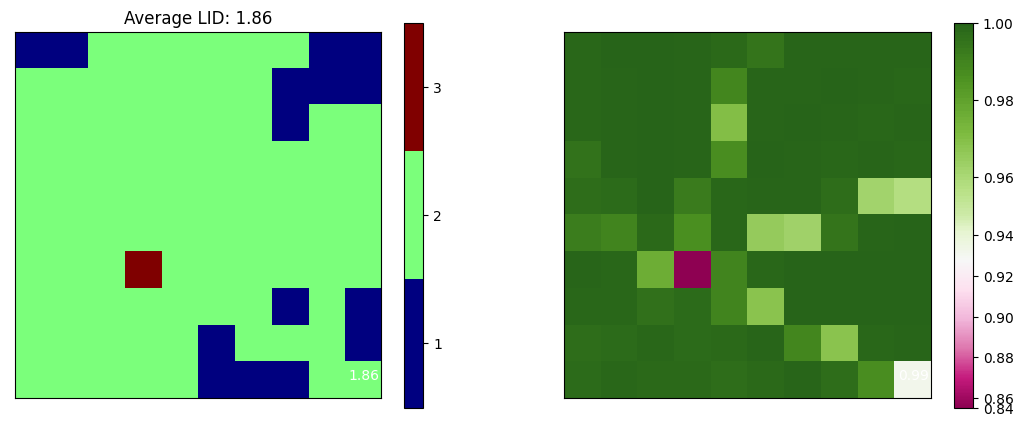

In [11]:
lid_finder = ID_finder_T(X_2d, DM=projecter, grid=10,  sample_size=55)
# lid_finder.get_LID(ssnp, grid=10, mode='dim')
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

lid_finder.plot_LID( mode='dim', ax=axes[0])
lid_finder.plot_LID( mode='percent', ax=axes[1], cmap='PiYG')

900it [00:24, 37.31it/s]


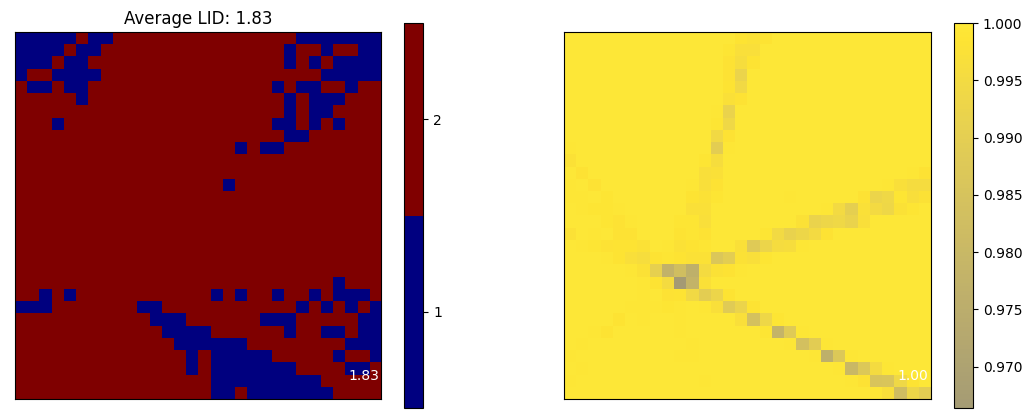

In [12]:
lid_finder = ID_finder_T(X_2d, DM=projecter, grid=30,  sample_size=55)
# lid_finder.get_LID(ssnp, grid=10, mode='dim')
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

lid_finder.plot_LID( mode='dim', ax=axes[0])
lid_finder.plot_LID( mode='percent', ax=axes[1], cmap='cividis', threshold=0.99)

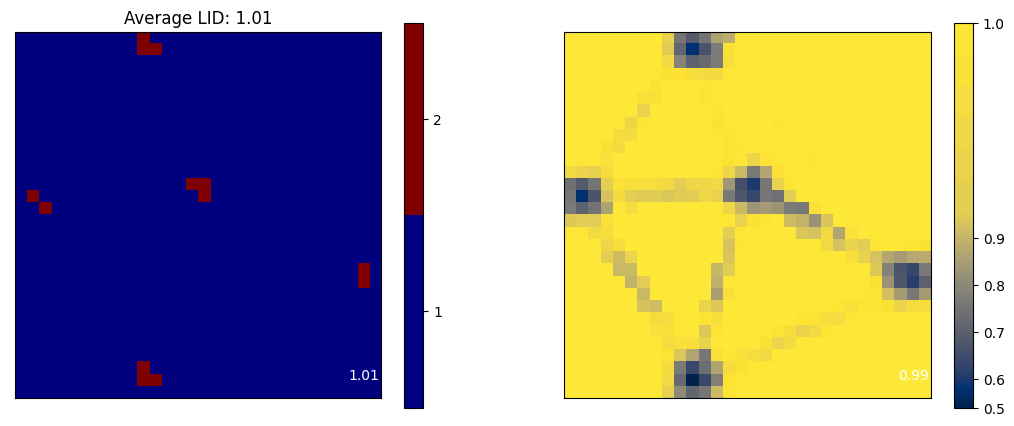

In [ ]:
# lid_finder = ID_finder_T(X_2d, DM=projecter, grid=30,  sample_size=55)
# lid_finder.get_LID(ssnp, grid=10, mode='dim')
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

lid_finder.plot_LID( mode='dim', ax=axes[0], threshold=0.50)
lid_finder.plot_LID( mode='percent', ax=axes[1], cmap='cividis')

10000it [01:57, 84.92it/s]


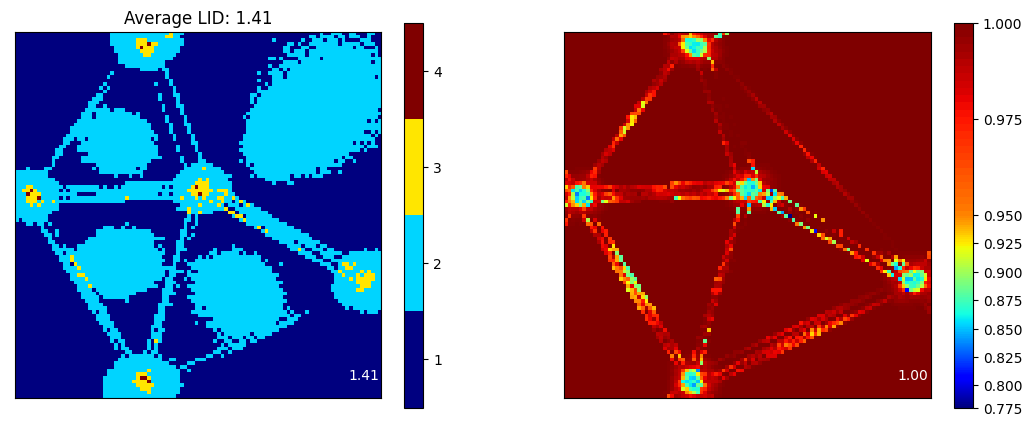

In [ ]:
lid_finder = ID_finder_T(X_2d, DM=projecter, grid=100,  sample_size=55)
# lid_finder.get_LID(ssnp, grid=10, mode='dim')
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

lid_finder.plot_LID( mode='dim', ax=axes[0])
lid_finder.plot_LID( mode='percent', ax=axes[1], threshold=0.95)

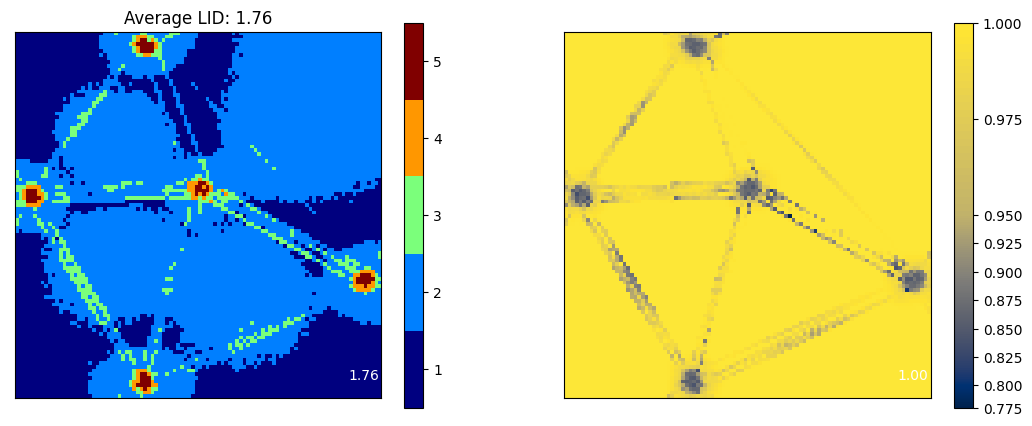

In [ ]:
# lid_finder = ID_finder_T(X_2d, DM=projecter, grid=100,  sample_size=55, threshold=0.99)
# lid_finder.get_LID(ssnp, grid=10, mode='dim')
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

lid_finder.plot_LID( mode='dim', ax=axes[0], threshold=0.99)
lid_finder.plot_LID( mode='percent', ax=axes[1],  cmap='cividis')

calculating probability map
calculating gradient map
2.5304263


<AxesSubplot: >

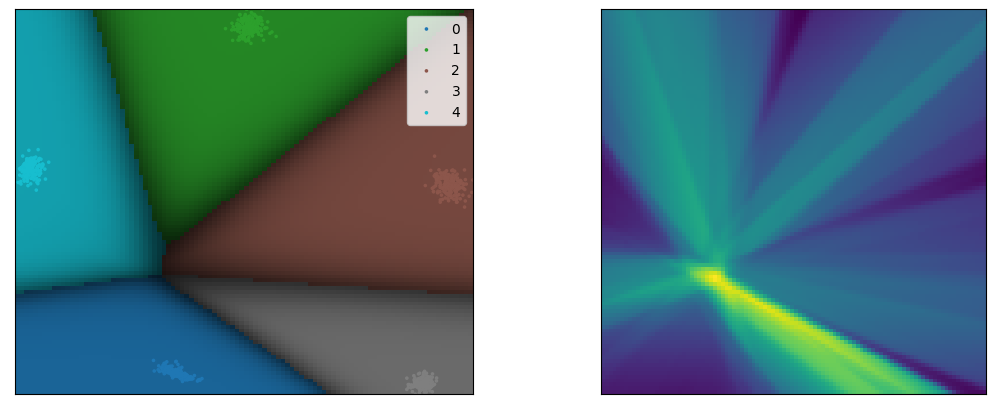

In [13]:
buider = MapBuilder(clf, projecter, X, y)
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
buider.plot_gradient_map(axes[1])
buider.plot_prob_map(axes[0])
buider.plot_training_data(axes[0])

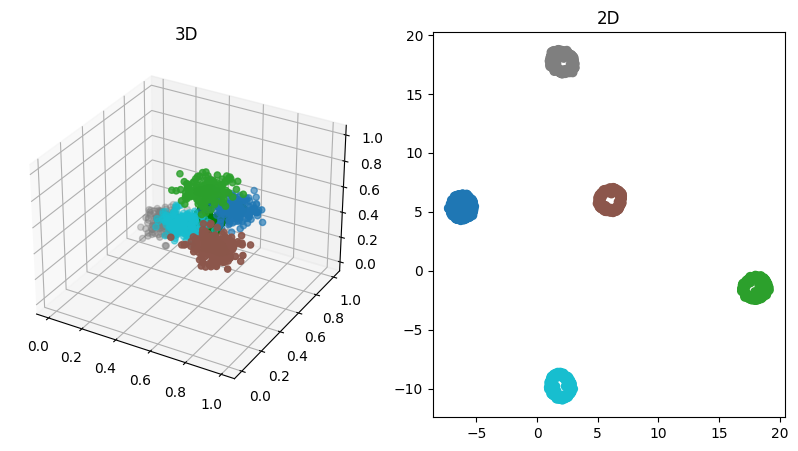

In [ ]:

fig0

In [ ]:
lid_finder.LID_map 

In [ ]:
lid_finder.LID_eval.min() 

tensor(-1.8827e-07, device='cuda:0')

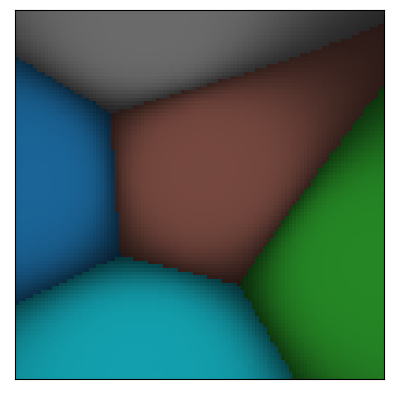

In [ ]:
ax = buider.plot_prob_map()
ax.set_aspect('equal')
# save ax as a image without any white space
fig = ax.get_figure()
fig.savefig('prob_map.png', bbox_inches='tight', pad_inches=-0.0, dpi=300)